## Import der benötigten Software Pakete

In [1]:
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from icl_lens_sizing.preprocessing.preprocessing import prepare_training_data

## Laden und Vorbereiten der Datensätze

In [2]:
path = "/Users/sortmanns/git/work/icl-lens-sizing/data/icl_data_2.csv"
df = pd.read_csv(path, sep=";", decimal=',')
df.head(10)

,befund_id,geschlecht,alter,auge,implantat_name,implantat_größe,Lens-ICPL-Distance,ACD,ACA_nasal,ACA_temporal,AtA,ACW,ARtAR_LR,StS,StS_LR,CBID,CBID_LR,mPupil,WtW_MS-39,WtW_IOL_Master,Sphaere,Zylinder,Achse,Referenz_Id
0,1,w,40.0,OD,IPCL V2.0,12.5,571,3.22,40.443,41.129,11.970,11.654,99,11.847,321,10.813,784,6.85,11.53,11.9,-6.5,-0.25,30,2.0
1,2,w,40.0,OS,IPCL V2.0,12.5,649,3.254,41.771,39.057,11.836,11.813,218,11.819,201,10.887,789,6.72,11.44,11.8,-6.75,-0.5,100,1.0
2,3,w,23.0,OD,IPCL V2.0,13,470,2.808,39.743,44.425,12.025,11.931,152,10.738,672,10.378,1.156,7.05,11.7,12.1,-6.75,-0.5,30,4.0
3,4,w,23.0,OS,IPCL V2.0,13,707,2.91,38.671,35.143,12.013,12.091,38,11.253,464,10.598,1.01,6.83,11.84,12.3,-6.25,-0.5,180,3.0
4,5,w,37.0,OD,IPCL V2.0,13.25,571,3.253,48.729,46.8,12.581,12.191,75,12.666,344,11.642,977,6.87,12.08,12.5,-10.25,-0.25,174,6.0
5,6,w,37.0,OS,IPCL V2.0,13.25,615,3.272,35.329,33.5,12.704,12.348,58,12.768,427,11.529,923,6.83,12.08,12.4,-11.5,-0.75,170,5.0
6,7,m,35.0,OD,IPCL V2.0,13,746,3.417,48.367,49.6,11.961,10.891,88,11.45,471,10.877,873,5.46,11.67,12.1,-5.25,-1,165,8.0
7,8,m,35.0,OS,IPCL V2.0,13,769,3.45,53.36,52.68,11.979,11.013,71,11.929,0.44,11.25,797,5.18,11.76,12.3,-5.75,-0.5,151,7.0
8,9,w,31.0,OS,IPCL V2.0,13.25,501,3.324,51.8,45.1,12.176,10.805,132,12.441,436,12.047,1.097,6.86,11.58,12.1,-4.5,-0.5,175,10.0
9,10,w,31.0,OD,IPCL V2.0,13.25,490,3.348,45.15,46.8,12.178,10.924,85,12.315,501,11.774,977,6.19,11.9,12.2,-3.5,-1.5,120,9.0


# Initiale Untersuchung der Einflussvariablen (Features)
Wir beginnen mit der vollen Feature-Menge, teilen die Daten in Feature- und Zielvariablen.

In [3]:
# Feature Auswahl
features = ['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

# Feature Engineering
custom_features = None
# Präparieren der Datensätze zur Weiterverarbeitung
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,
                                                               custom_features=custom_features)

In [4]:
standard_scaler = StandardScaler()
lasso_model = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', lasso_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

156.7031222223562


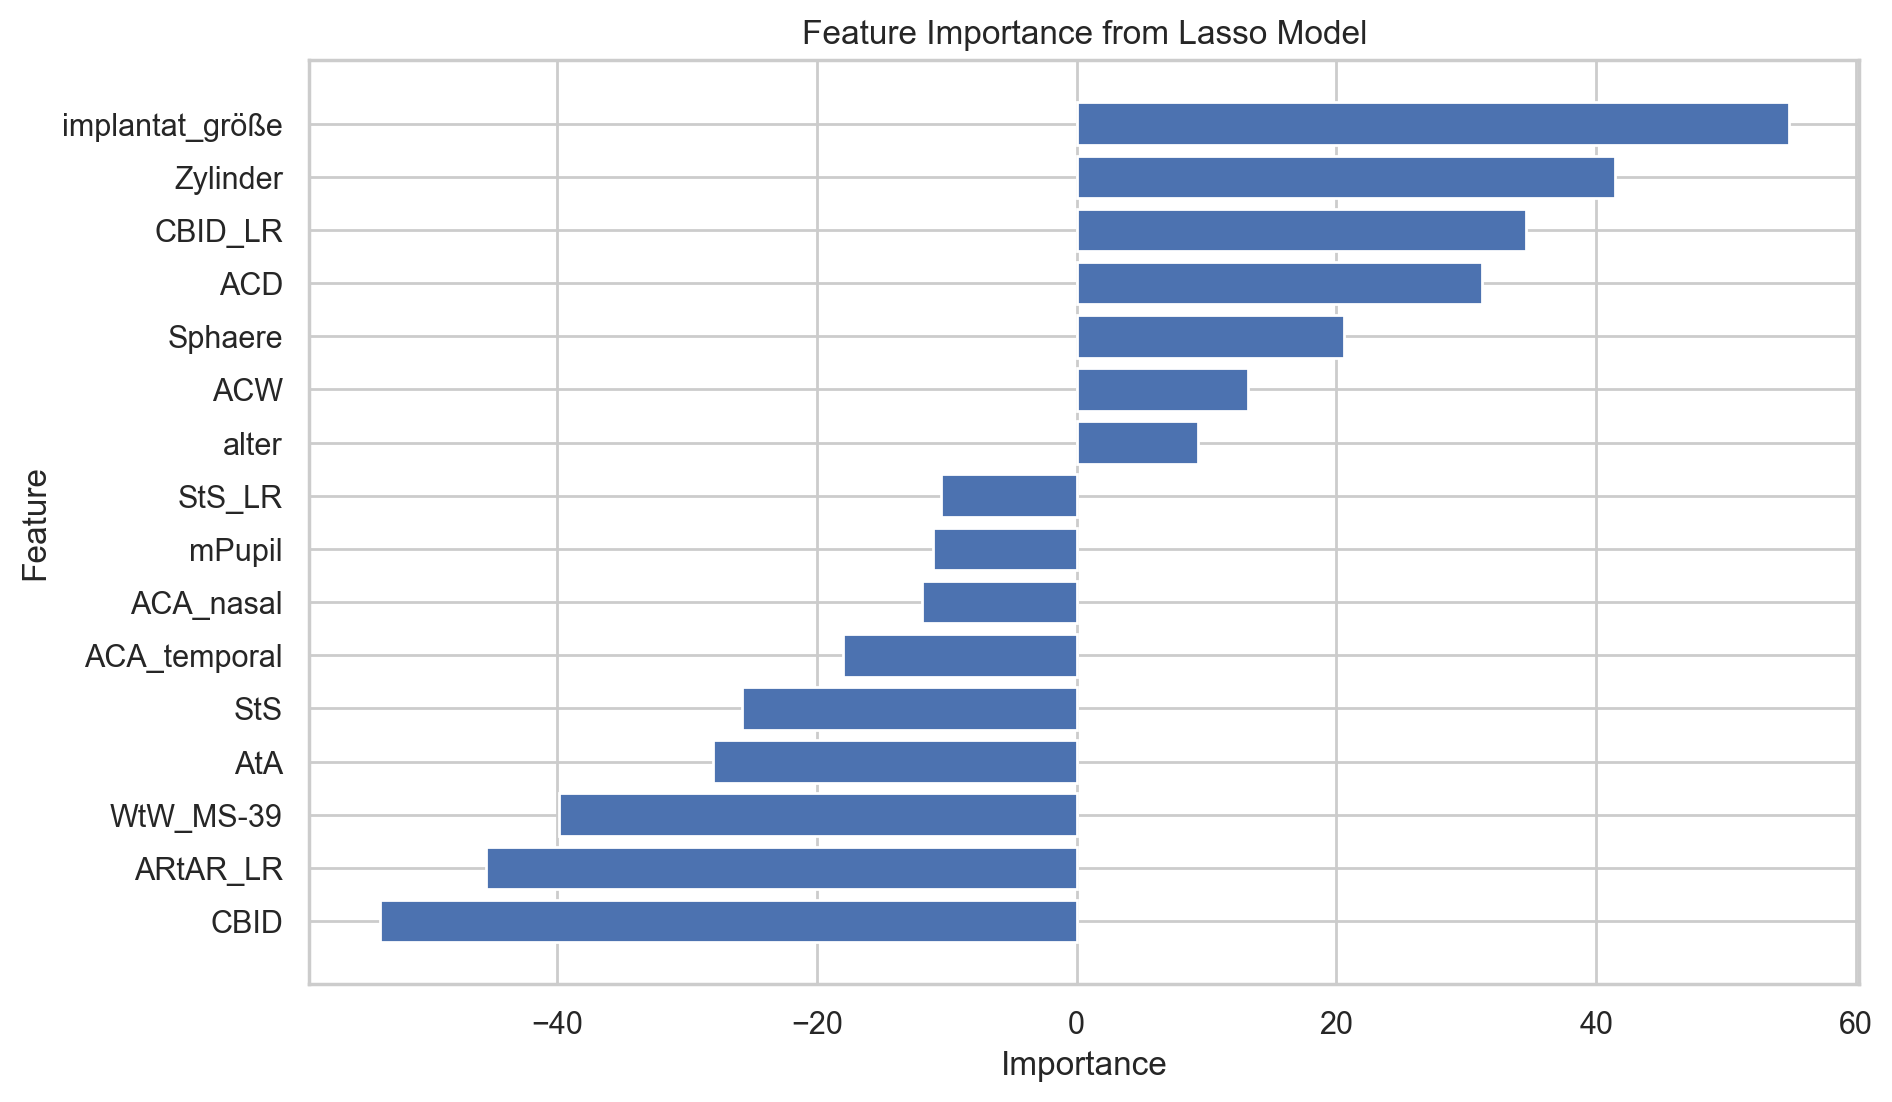

In [5]:
# Fit the pipeline on your data
pipeline.fit(feature_df, target_df)

# Get the Lasso model from the pipeline
lasso_model = pipeline.named_steps['estimator']

# Get the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

## Sequential Feature Selection

In [6]:
# prepare data
features = ['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)

lasso_model = Lasso()
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
sfsb = SequentialFeatureSelector(
    estimator=lasso_model,
    direction="backward",
    scoring="neg_mean_absolute_error"
)
sfsb.fit(feature_df, target_df)

/Users/sortmanns/mambaforge/envs/icl-sizing/lib/python3.8/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


SequentialFeatureSelector(direction='backward', estimator=Lasso(),
                          scoring='neg_mean_absolute_error')

In [7]:
sfsb.get_feature_names_out()

array(['ACA_nasal', 'ACA_temporal', 'AtA', 'ACW', 'ARtAR_LR', 'StS',
       'WtW_MS-39', 'Sphaere'], dtype=object)

In [15]:
features = ['ACA_nasal', 'ACA_temporal', 'AtA', 'ACW', 'ARtAR_LR', 'StS',
       'WtW_MS-39', 'Sphaere']
custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
standard_scaler = StandardScaler()
lasso_model = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', lasso_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

117.78042232566881


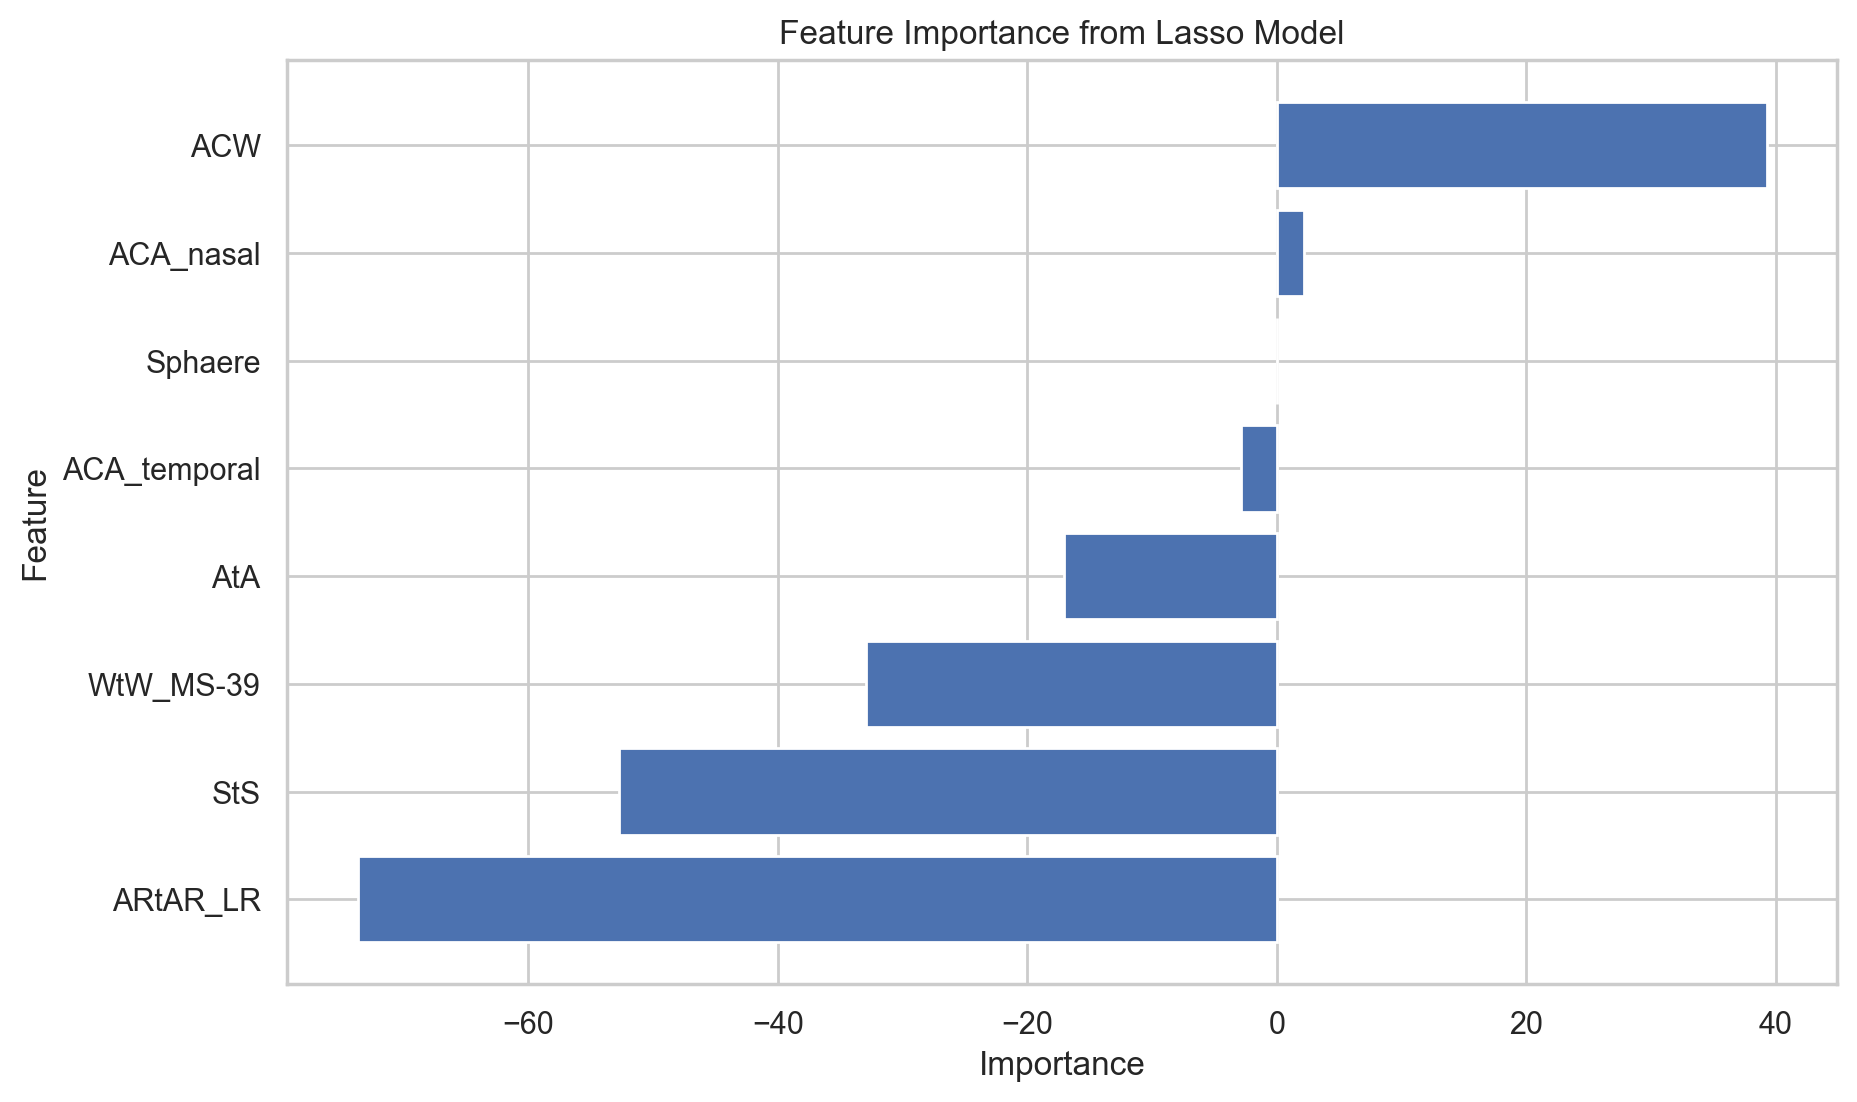

In [16]:
# Fit the pipeline on your data
pipeline.fit(feature_df, target_df)

# Get the Lasso model from the pipeline
lasso_model = pipeline.named_steps['estimator']

# Get the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

In [17]:
lasso_model = Lasso()
features = ['implantat_größe', 'alter', 'ACD', 'ACA_nasal', 'ACA_temporal', 'AtA', 'ACW',
            'ARtAR_LR', 'StS', 'StS_LR', 'CBID', 'CBID_LR', 'mPupil', 'WtW_MS-39', 'Sphaere', 'Zylinder']

custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Store column names
column_names = feature_df.columns.tolist()

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(feature_df)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

# Make sure indices are aligned
scaled_df.index = feature_df.index
target_df.index = feature_df.index

X_ols = sm.add_constant(scaled_df, has_constant='add')
sfsf = SequentialFeatureSelector(
    estimator=lasso_model,
    direction="forward",
    scoring="neg_mean_absolute_error"
)
sfsf.fit(feature_df, target_df)
sfsf.get_feature_names_out()

/Users/sortmanns/mambaforge/envs/icl-sizing/lib/python3.8/site-packages/sklearn/feature_selection/_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


array(['implantat_größe', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'WtW_MS-39', 'Sphaere'], dtype=object)

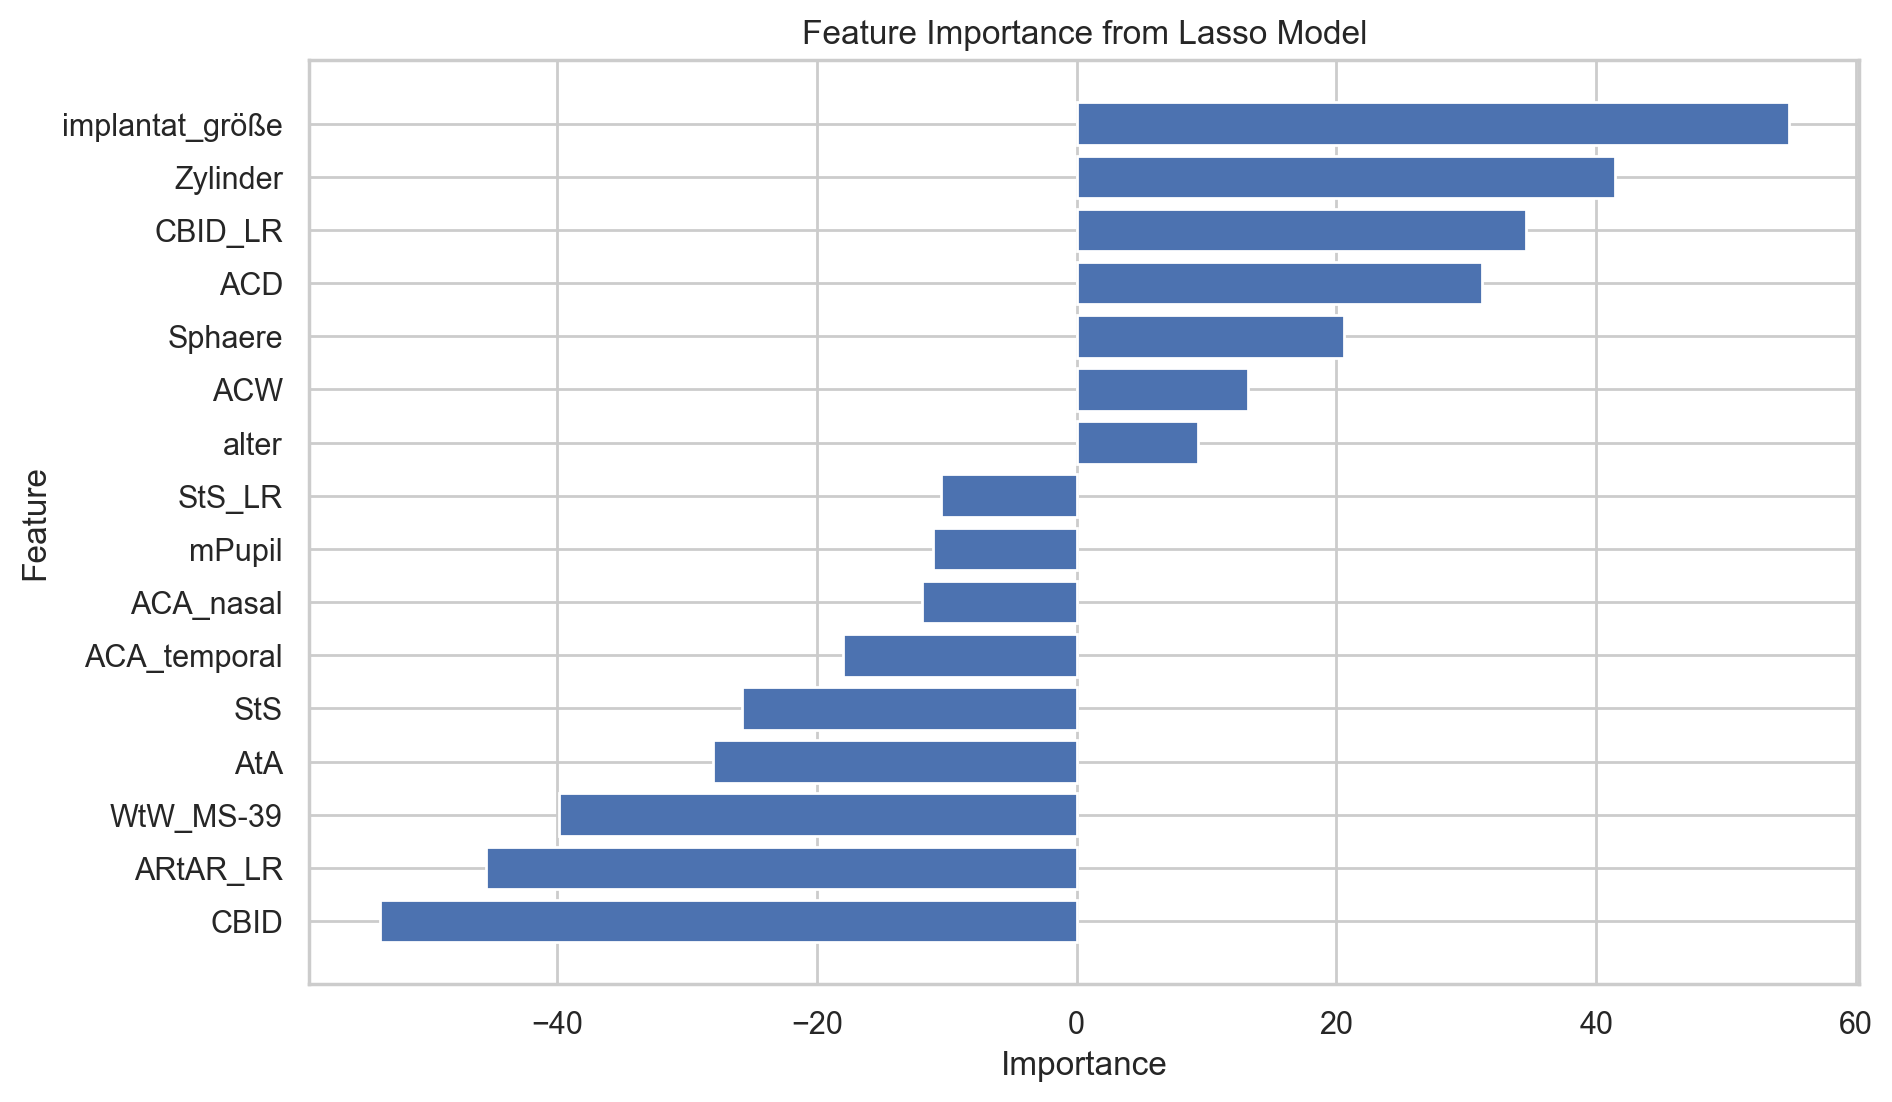

In [18]:
# Fit the pipeline on your data
pipeline.fit(feature_df, target_df)

# Get the Lasso model from the pipeline
lasso_model = pipeline.named_steps['estimator']

# Get the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

In [19]:
features = ['implantat_größe', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'WtW_MS-39', 'Sphaere']
custom_features = None
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
standard_scaler = StandardScaler()
lasso_model = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', lasso_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

120.63794484539213


# Feature Engineering

In [21]:
features = ['implantat_größe', 'AtA', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'WtW_MS-39', 'Sphaere']
sts_cbid = (lambda row: (row['StS'] + row['CBID'])/2)
custom_features = {'sts_cbid':sts_cbid}
df['StS'] = df['StS'].to_numpy('double')
df['CBID'] = df['CBID'].to_numpy('double')
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
feature_df = feature_df.drop(columns=['StS', 'CBID'])
standard_scaler = StandardScaler()
lasso_model = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', lasso_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

116.00068816222256


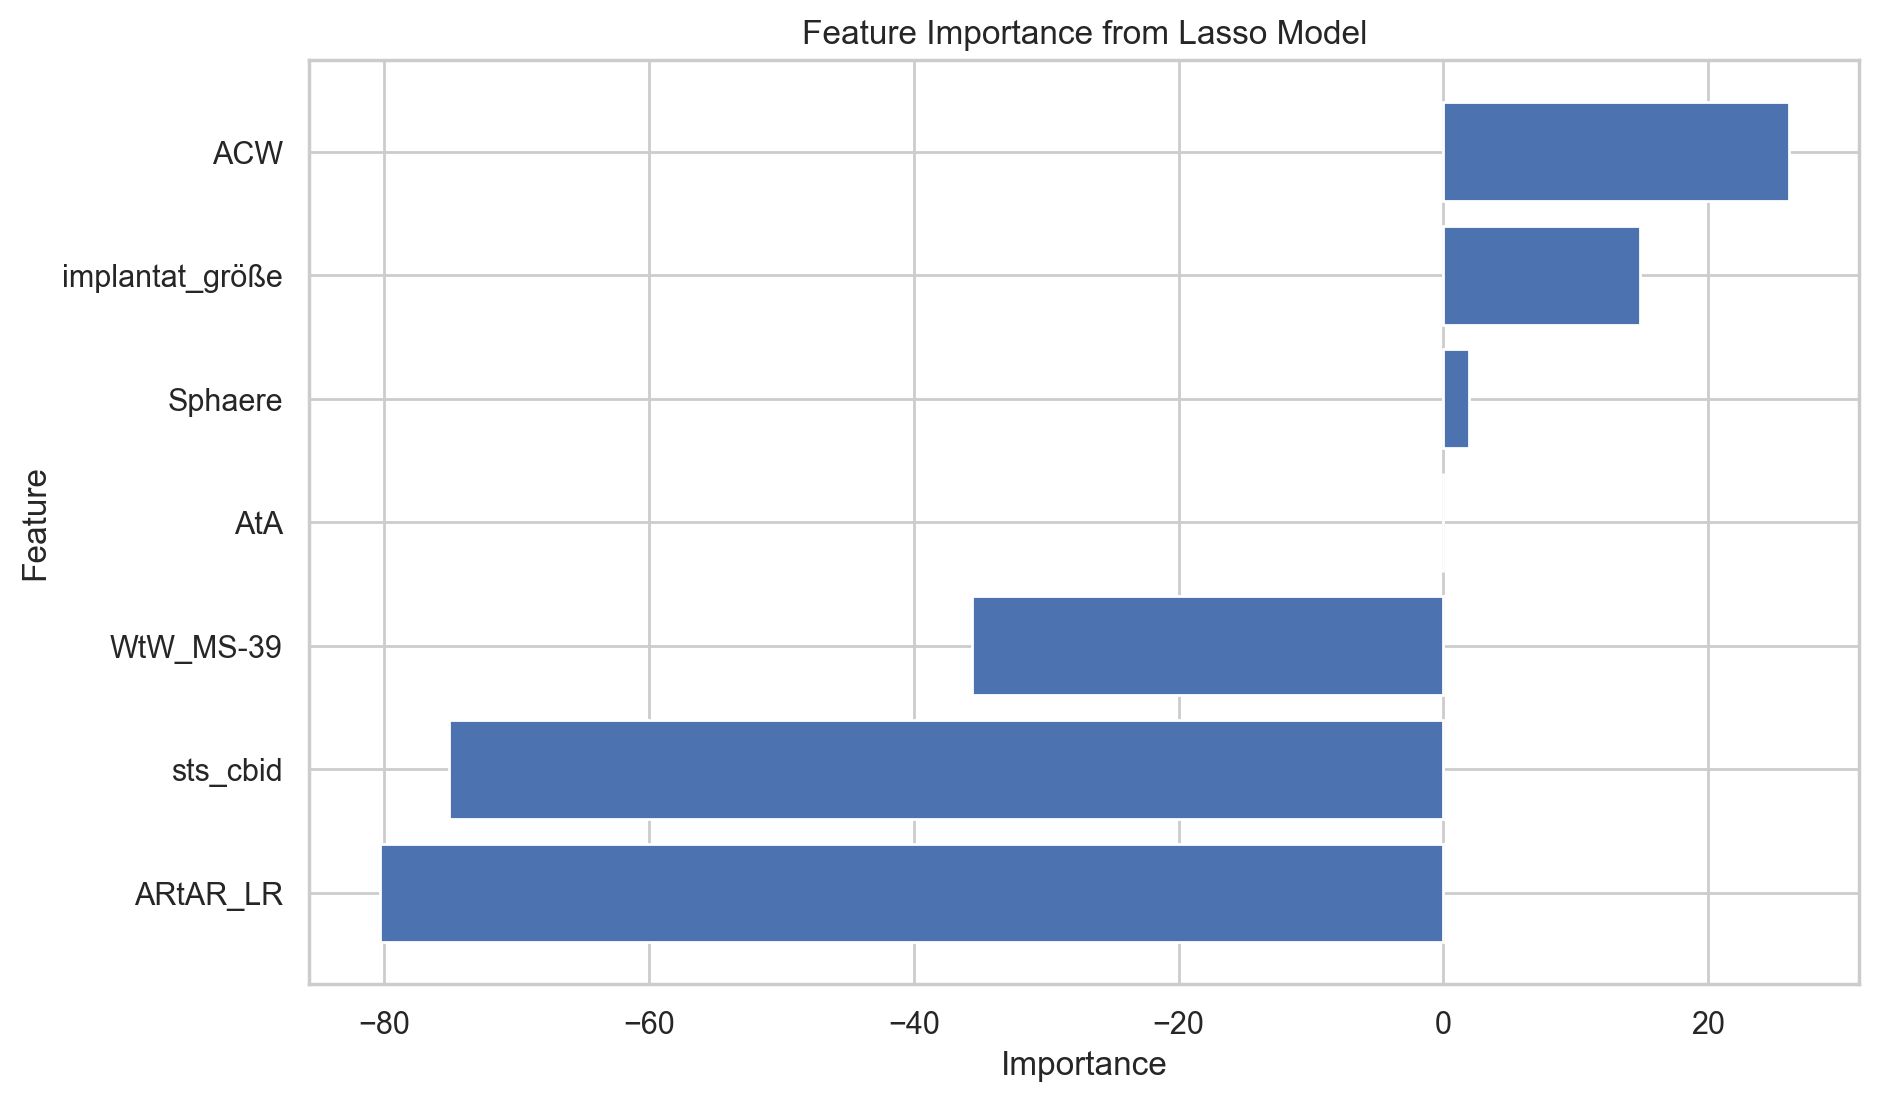

In [22]:
# Fit the pipeline on your data
pipeline.fit(feature_df, target_df)

# Get the Lasso model from the pipeline
lasso_model = pipeline.named_steps['estimator']

# Get the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

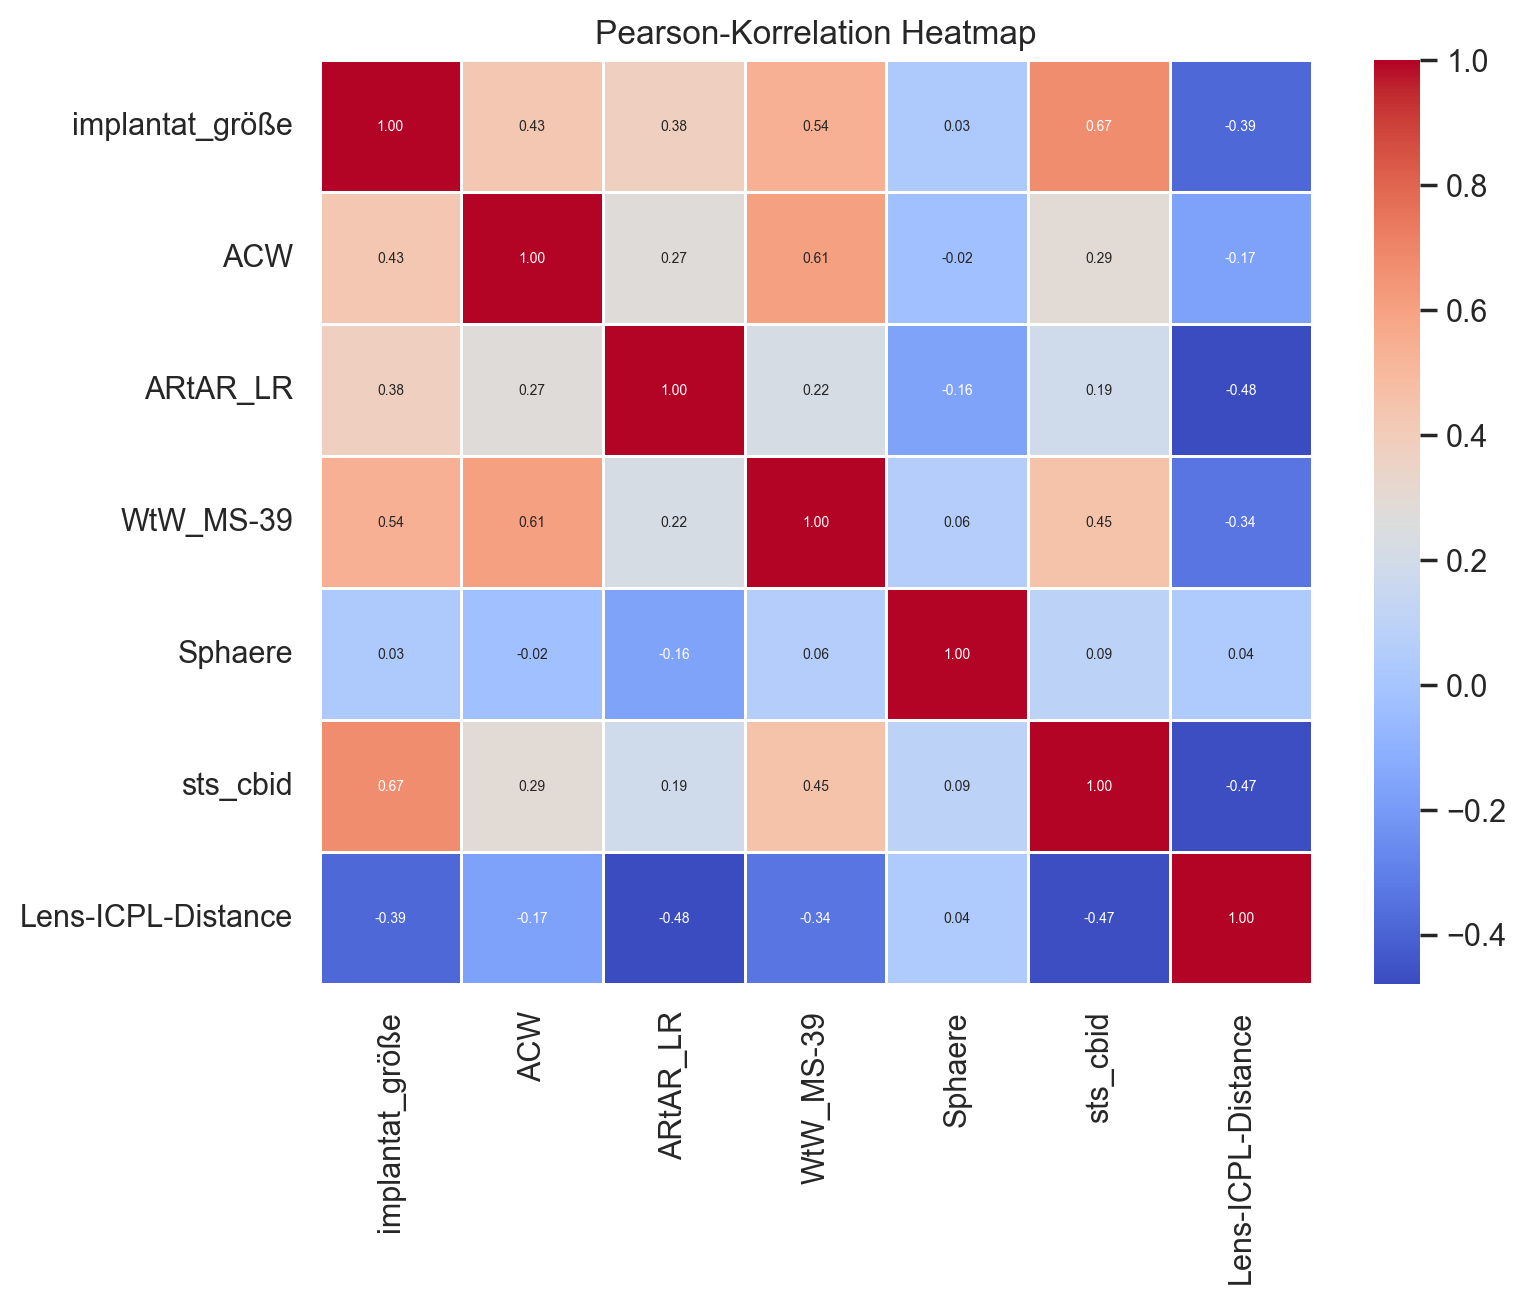

In [39]:
# Create a StandardScaler object
scaler = StandardScaler()

column_names = list(feature_df.columns) + ['Lens-ICPL-Distance']

full_df = pd.concat([feature_df, target_df], axis=1)

# Fit and transform the DataFrame using the scaler
scaled_data = scaler.fit_transform(full_df)
# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_corr_matrix = scaled_df.corr()

# Heatmap erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(scaled_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 5})
plt.title('Pearson-Korrelation Heatmap')
plt.show()

In [42]:
features = ['implantat_größe', 'ACW', 'ARtAR_LR', 'StS', 'CBID',
       'WtW_MS-39', 'Sphaere']
df['implantat_größe'] = df['implantat_größe'].to_numpy('double')
sts_cbid = (lambda row: ((row['StS'] + row['CBID'])/2)-row['implantat_größe'])
custom_features = {'sts_cbid':sts_cbid}
feature_df, target_df, feature_mapping = prepare_training_data(df=df, target="Lens-ICPL-Distance", features=features,custom_features=custom_features)
# Create a StandardScaler object
feature_df = feature_df.drop(columns=['StS', 'CBID', 'implantat_größe'])
standard_scaler = StandardScaler()
lasso_model = Lasso()
pipeline = Pipeline([('transformer', standard_scaler), ('estimator', lasso_model)])
print((-1)*cross_val_score(pipeline, feature_df, target_df, cv=5, scoring='neg_mean_absolute_error').mean())

112.11949630926412


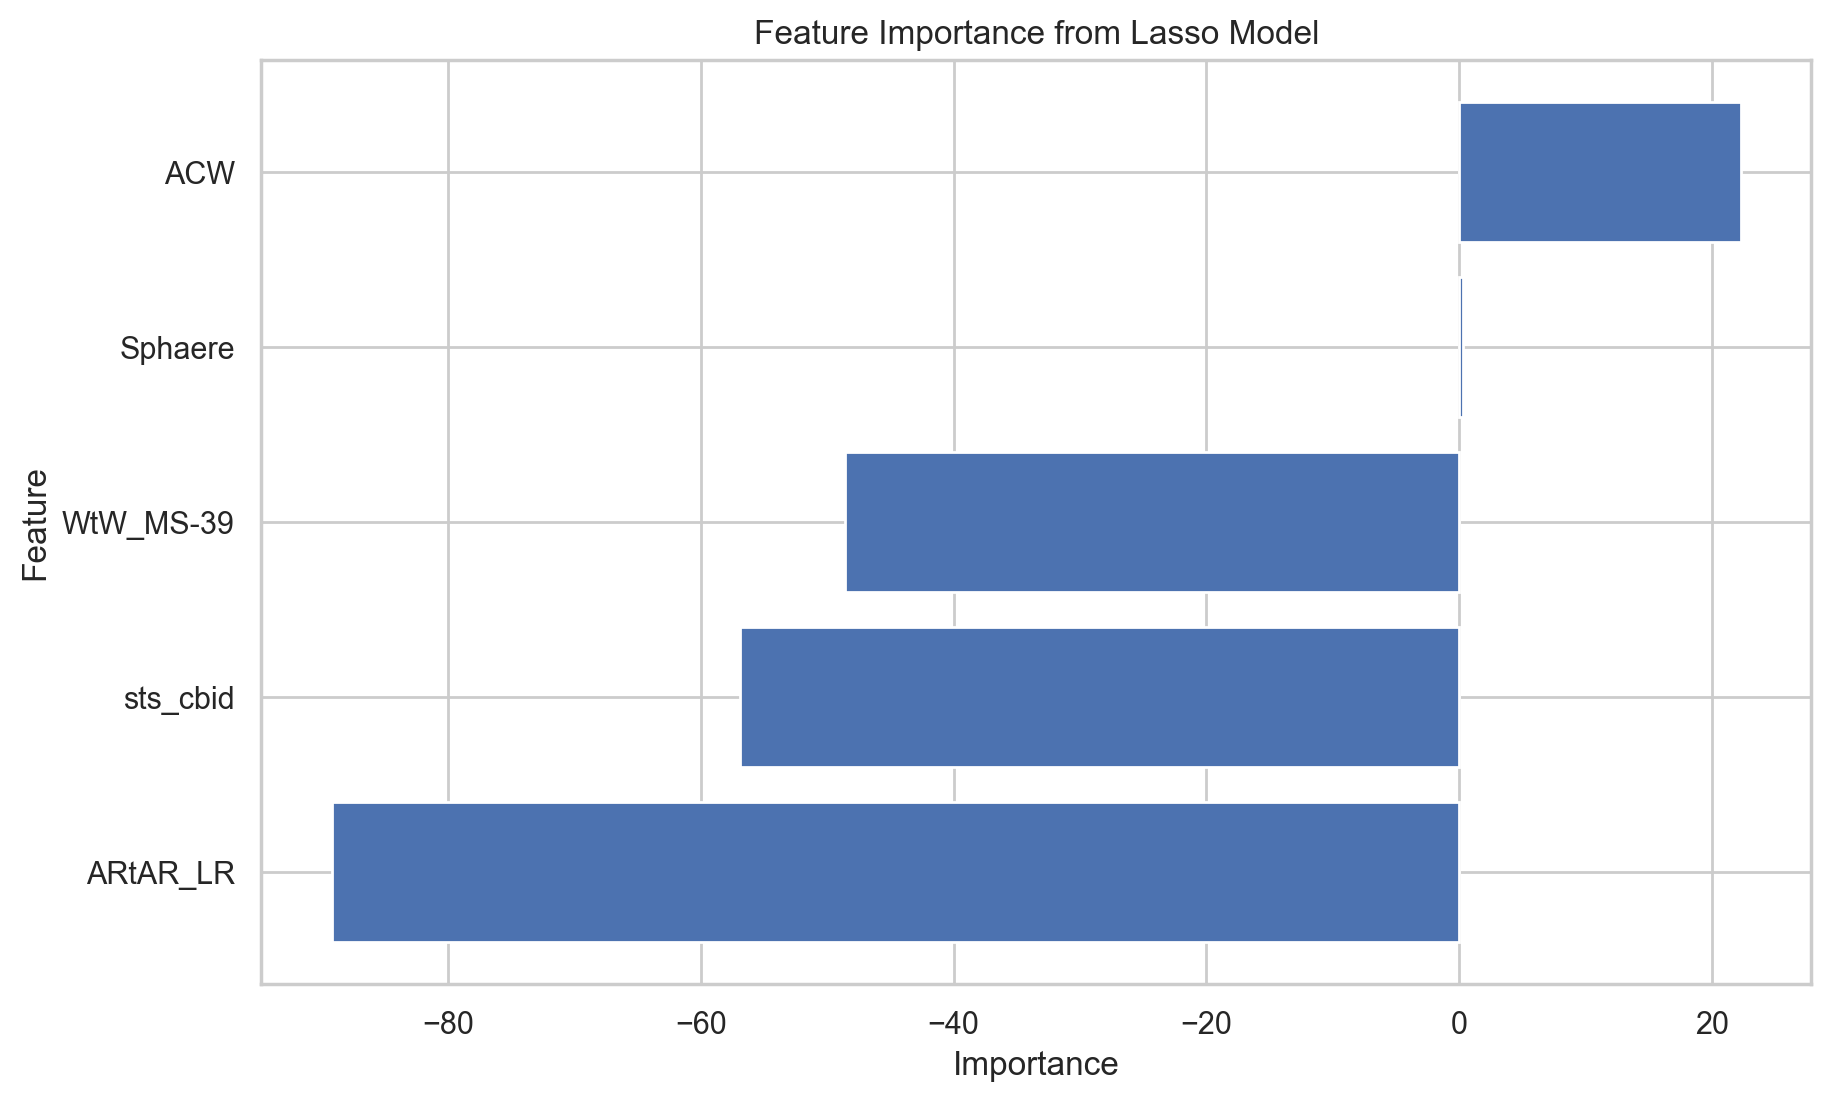

In [43]:
# Fit the pipeline on your data
pipeline.fit(feature_df, target_df)

# Get the Lasso model from the pipeline
lasso_model = pipeline.named_steps['estimator']

# Get the feature importance (coefficients) from the Lasso model
feature_importance = lasso_model.coef_

# Create a DataFrame to hold feature names and their corresponding importance values
feature_importance_df = pd.DataFrame({'Feature': feature_df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Lasso Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

In [ ]:
# # Set the target value
# target_value = 500
#

In [ ]:
# df = pd.read_csv("../data/Vault_postOP.csv", sep=";")
# df["Differenz zu 500"].to_numpy()
#

In [ ]:
# radii = np.abs(df["Differenz zu 500"].to_numpy())
# angles = np.random.uniform(0, 2 * np.pi, len(radii))
# x_discrepancies = radii * np.cos(angles)
# y_discrepancies = radii * np.sin(angles)
#
# # Calculate the actual values
# x_actuals = target_value + x_discrepancies
# y_actuals = target_value + y_discrepancies
#
# # Create a scatter plot
# plt.figure(figsize=(8, 8))
# plt.scatter(x_actuals, y_actuals, c='blue', s=30, alpha=0.5, label='Actual Values')
# plt.axhline(target_value, color='red', linestyle='--', linewidth=2, label='Target Value')
# plt.axvline(target_value, color='red', linestyle='--', linewidth=2)
# plt.xlabel('X Actual Values')
# plt.ylabel('Y Actual Values')
# plt.title('Accuracy Visualization with Crosshair Pattern')
# plt.legend()
# plt.grid(True)
#
# # Display the plot
# plt.show()
#

In [ ]:
# # Create a figure and axis
# fig, ax = plt.subplots()
#
# # Define the center
# center = (500, 500)
#
# # Define the number of circles and the distance between them
# num_circles = 3
# distance_between_circles = 100
# circle_colors = []
# # Draw three red dotted circles with the specified center and distances
# for i in range(num_circles):
#     radius = (i + 1) * distance_between_circles
#     circle = plt.Circle(center, radius, color='red', fill=False, linestyle='dotted')
#     ax.add_artist(circle)
#
#     # Determine the color based on the radius
#     if radius < 100:
#         circle_colors.append('green')
#     elif 100 <= radius <= 250:
#         circle_colors.append('orange')
#
# # Set the aspect ratio to be equal (so circles look like circles)
# ax.set_aspect('equal')
#
# # Set the axis limits
# ax.set_xlim(100, 900)
# ax.set_ylim(100, 900)
#
# # Plot the points from the previous example
# # You can modify these coordinates based on your data
# plt.scatter(x_actuals, y_actuals, c='blue', s=30, alpha=0.5, label='Actual Values')
#
# # Fill the circles with their respective colors
# for i, color in enumerate(circle_colors):
#     ax.add_patch(plt.Circle(center, (i + 1) * distance_between_circles, color=color, alpha=0.2))
#
# # Set axis labels and title
# ax.set_xlabel('achieved vault')
# ax.set_ylabel('achieved vault')
# ax.set_title('ICL Surgery Precision')
#
# # Show the plot
# plt.grid(True)
# plt.legend()
# plt.show()